## How to call immune subtypes on new data ##

Let's suppose you have some:
  a.) RPKM (or FPKM or something equivlent) gene expression data 
  b.) Has hg19 gene symbols mapped to it.
  c.) knowledge on how to batch correct / normalize it with regard to TCGA PanCancer data*
  
and you'd like to call some immune subtypes on those samples.

In [2]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
#loading TCGA PanCancer EB++ expression data, subset to the pertinent genes.

tcgaSubset <- read.table('../shiny-app/Immune-Subtype-Clustering/data/ebppSubset.tsv.bz2', header = T, sep = '\t', stringsAsFactors = F)
dim(tcgaSubset)
tcgaSubset[1:4,1:5]

[1] 2316 9129

,TCGA.OR.A5J1.01A.11R.A29S.07,TCGA.OR.A5J2.01A.11R.A29S.07,TCGA.OR.A5J3.01A.11R.A29S.07,TCGA.OR.A5J5.01A.11R.A29S.07,TCGA.OR.A5J6.01A.31R.A29S.07
A1CF,0.0000,0.000,0.5925,1.5492,0.000
ABCA1,319.4040,1071.800,896.4600,310.6120,800.283
ABCA8,4.3228,121.997,1368.6900,982.1840,5000.650
ABCB11,0.4803,0.000,1.7775,0.0000,0.000


In [4]:
# need to subset before transforms
reportedScores <- read.table('../shiny-app/Immune-Subtype-Clustering//data//five_signature_mclust_ensemble_results.tsv.gz', sep='\t', header=T, stringsAsFactors = F)
head(reportedScores)
rownames(reportedScores) <- reportedScores$AliquotBarcode

AliquotBarcode,SampleBarcode,ClusterModel1,ClusterModel2,LIexpression_score,CSF1_response,TGFB_score_21050467,Module3_IFN_score,CHANG_CORE_SERUM_RESPONSE_UP
TCGA.02.0047.01A.01R.1849.01,TCGA-02-0047-01A,4,4,-1.3536972,0.8995777,0.09838865,-0.43775189,-0.5989618
TCGA.02.0055.01A.01R.1849.01,TCGA-02-0055-01A,4,4,-0.5016848,1.4674281,1.41870736,0.03473346,0.6990816
TCGA.02.2483.01A.01R.1849.01,TCGA-02-2483-01A,4,4,-0.9197809,0.4884155,-0.50393689,-0.68551726,1.0855086
TCGA.02.2485.01A.01R.1849.01,TCGA-02-2485-01A,4,4,-0.7810493,0.1039455,-0.65700848,1.49949319,0.4496605
TCGA.02.2486.01A.01R.1849.01,TCGA-02-2486-01A,4,4,-0.0361280,1.8245642,-0.27930992,2.53785832,0.1475449
TCGA.04.1348.01A.01R.1565.13,TCGA-04-1348-01A,2,2,0.6439911,0.7957605,-0.63769666,0.90119552,1.8003985


In [5]:
tcgaSubset <- log2(tcgaSubset + 1)

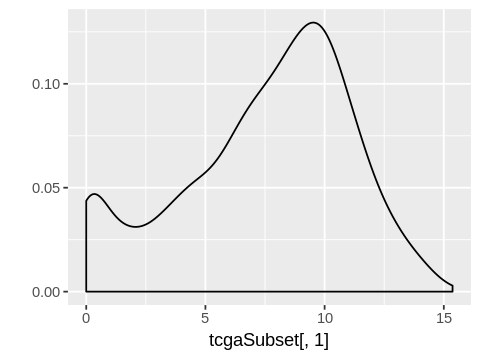

In [6]:
qplot(tcgaSubset[,1], geom='density')

In [7]:
# bring in the new data #
# found some RPKM RNA-seq data
# 
load('../ExtraData/newDat.rda')
dim(newDat)
newDat[1:5,1:5]

[1] 20130     6

,rpkm.exp_005_shNTC_rep1,rpkm.exp_005_shNTC_rep2,rpkm.exp_005_shNTC_rep3,rpkm.exp_005_shTRPS1_seq1,rpkm.exp_005_shTRPS1_seq2
TSPAN6,4.866946,5.59851858,6.0323073,8.81300835,7.31116077
DPM1,14.703788,14.54414233,15.2178512,13.48725417,14.18521178
SCYL3,2.613824,2.62848323,2.6941885,2.33930243,2.61831372
C1orf112,2.130704,1.95809753,1.9696715,1.48692841,1.51562986
FGR,0.000000,0.02082027,0.0149617,0.01707083,0.01057218


In [8]:
# here we'll drop any duplicate genes, and make the rownames
# be gene symbols

didx <- !duplicated(as.character(rownames(newDat)))
dat <- newDat[didx,]
dim(dat)
dat[1:5,1:5]

[1] 20130     6

,rpkm.exp_005_shNTC_rep1,rpkm.exp_005_shNTC_rep2,rpkm.exp_005_shNTC_rep3,rpkm.exp_005_shTRPS1_seq1,rpkm.exp_005_shTRPS1_seq2
TSPAN6,4.866946,5.59851858,6.0323073,8.81300835,7.31116077
DPM1,14.703788,14.54414233,15.2178512,13.48725417,14.18521178
SCYL3,2.613824,2.62848323,2.6941885,2.33930243,2.61831372
C1orf112,2.130704,1.95809753,1.9696715,1.48692841,1.51562986
FGR,0.000000,0.02082027,0.0149617,0.01707083,0.01057218


In [9]:
# the TCGA data was upper quantile normalized (*1000)

data.quantileExpressed <- apply(dat, 2, function(x){quantile(x[x>0], 0.75)})

datnorm <- as.data.frame(t( t(dat) / data.quantileExpressed ) ) * 1000

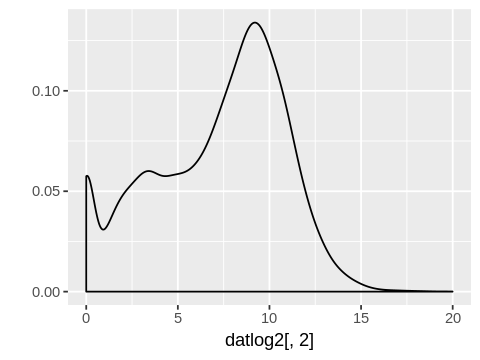

In [10]:
# then we take the log2 of the normalized data
# and similar to the TCGA data, we see a large 
# peak a little before 10

datlog2 <- log2(datnorm+1)
qplot(datlog2[,2], geom='density')

In [12]:
datlog2[1:5,1:5]

,rpkm.exp_005_shNTC_rep1,rpkm.exp_005_shNTC_rep2,rpkm.exp_005_shNTC_rep3,rpkm.exp_005_shTRPS1_seq1,rpkm.exp_005_shTRPS1_seq2
TSPAN6,9.636225,9.847643,9.945704,10.617817,10.355048
DPM1,11.230111,11.224001,11.279804,11.231389,11.310729
SCYL3,8.740932,8.758597,8.784657,8.706800,8.875558
C1orf112,8.446865,8.334959,8.333964,8.055034,8.089071
FGR,0.000000,2.144950,1.783875,2.015010,1.532297


In [13]:
# clean up
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,805632,43.1,4921074,262.9,8595245,459.1
Vcells,27370258,208.9,91845090,700.8,91845052,700.8


In [14]:
### joining data sets ###
sharedGenes  <- intersect(rownames(tcgaSubset), rownames(dat))

# first median scale each data set
newDatSub    <- datlog2[sharedGenes,]
newDatSubMeds<- apply(newDatSub, 1, median, na.rm=T)  
newDatSub    <- sweep(newDatSub,1,newDatSubMeds,'-')


In [59]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3833188,204.8,6801121,363.3,8595245,459.1
Vcells,47789078,364.7,153034414,1167.6,275934593,2105.3


In [16]:
dim(dat)
dim(newDatSub)
length(sharedGenes)

[1] 20130     6

[1] 2227    6

[1] 2227

In [17]:
dim(tcgaSubset)

[1] 2316 9129

In [18]:
tcgaSubsetSub <- tcgaSubset[sharedGenes,]
rm(tcgaSubset)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,806991,43.1,3149487,168.3,8595245,459.1
Vcells,26581173,202.8,91845090,700.8,91845052,700.8


In [19]:
# getting the medians of each gene
tcgaSubsetSubMeds <- apply(tcgaSubsetSub, 1, median, na.rm=T)
head(tcgaSubsetSubMeds)

A1CF    ABCA1    ABCA8   ABCB11    ABCB1    ABCC3 
0.000000 9.871967 5.832206 0.503654 6.548187 9.564424

In [20]:
# here we median center each gene
tcgaSubsetSub <- sweep(tcgaSubsetSub,1,tcgaSubsetSubMeds,'-')  

In [58]:
rm(dat, datlog2, didx, newDat)
gc()

Warning message in rm(dat, datlog2, didx, newDat):
“object 'dat' not found”Warning message in rm(dat, datlog2, didx, newDat):
“object 'datlog2' not found”Warning message in rm(dat, datlog2, didx, newDat):
“object 'didx' not found”Warning message in rm(dat, datlog2, didx, newDat):
“object 'newDat' not found”

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3833234,204.8,6801121,363.3,8595245,459.1
Vcells,47789266,364.7,153034414,1167.6,275934593,2105.3


In [22]:
library(pryr)
mem_used()

256 MB

In [23]:
# then join the new data and tcga data at the genes
joinDat <- cbind(newDatSub, tcgaSubsetSub)

dim(joinDat)

[1] 2227 9135

In [46]:
#let's look at the distribution of the data pre-batch-correction
  newdatSamples <- colnames(newDatSub)
  dat2idx <- 1:(ncol(newDatSub)-1)
  tcgaidx <- setdiff( (1: (ncol(joinDat)-1)), dat2idx)

  sampleIdx <- c(dat2idx, sample(tcgaidx, size=200, replace = F))
  preCombat <- joinDat[,sampleIdx]
  preCombatMelt <- reshape2::melt(preCombat)
  preCombatMelt$SampleSource <- ifelse(test = preCombatMelt$variable %in% newdatSamples, yes = "New Data", no="TCGA Data")


No id variables; using all as measure variables


In [24]:
library(sva)

combatflag <- 1
if (combatflag) {
    # then batch correction between scores...
    batch <- c(rep(1,ncol(newDatSub)), rep(2,ncol(tcgaSubsetSub)))
    modcombat = model.matrix(~1, data=as.data.frame(t(joinDat)))
    combat_edata = ComBat(dat=joinDat, batch=batch, mod=modcombat, 
                          par.prior=TRUE, prior.plots=FALSE, ref.batch = 2)
} else {
    combat_edata = joinDat    
}

dim(combat_edata)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-27. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel


Using batch = 2 as a reference batch (this batch won't change)


Found2batches
Adjusting for0covariate(s) or covariate level(s)
Found39158Missing Data Values 


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



[1] 2227 9135

In [47]:
# then look at the distribution of the data after batch correction
postCombat <- combat_edata[,sampleIdx]
postCombatMelt <- reshape2::melt(postCombat)
postCombatMelt$SampleSource <- ifelse(test = postCombatMelt$variable %in% newdatSamples, yes = "New Data", no="TCGA Data")


No id variables; using all as measure variables


Warning message:
“Removed 1044 rows containing non-finite values (stat_density).”

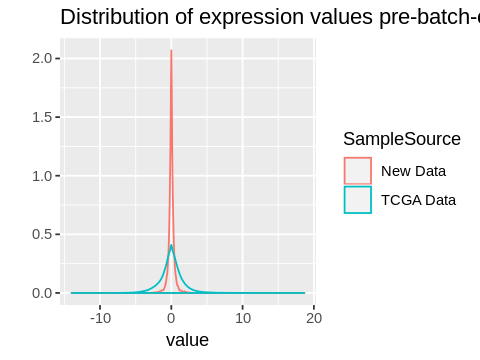

In [50]:
qplot(data=preCombatMelt, col=SampleSource, x=value, geom='density', main = 'Distribution of expression values pre-batch-correction')

Warning message:
“Removed 1044 rows containing non-finite values (stat_density).”

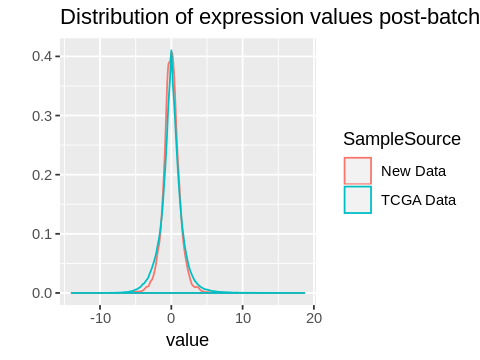

In [53]:
qplot(data=postCombatMelt, col=SampleSource, x=value, geom='density', main = 'Distribution of expression values post-batch-correction')

In [26]:
# then let's get all the genes we need for the 5 signatures
load('../shiny-app/Immune-Subtype-Clustering/data/comparative_immuneSigs_geneLists4.rda')

# and we use the scoring code to produce scores #
source('../shiny-app/Immune-Subtype-Clustering/src/ImmuneSigs68_function.R')

In [27]:
### compute the signature scores.

scores <- ImmuneSigs_function(combat_edata, sigs1_2_eg2,sigs12_weighted_means,
                                 sigs12_module_weights,sigs1_2_names2,sigs1_2_type2)

print(dim(scores))
scores[1:5,1:5]

[1] "DONE MEAN"
[1] "DONE MEDIAN"
[1] "DONE WEIGHTED MEAN"
[1] "DONE MODULES"
[1] "DONE CHANG CORE"
[1] "DONE PCA"
[1] "DONE DONE"
[1]    5 9135


,rpkm.exp_005_shNTC_rep1,rpkm.exp_005_shNTC_rep2,rpkm.exp_005_shNTC_rep3,rpkm.exp_005_shTRPS1_seq1,rpkm.exp_005_shTRPS1_seq2
LIexpression_score,-0.3247,0.0434,-1.1721,0.2133,0.2962
CSF1_response,-0.1689,-0.1549,-0.4606,0.6019,0.0798
TGFB_score_21050467,-0.2967,-0.2110,-0.3596,0.3557,0.2123
Module3_IFN_score,1.4617,0.6730,0.6536,0.1667,-1.3993
CHANG_CORE_SERUM_RESPONSE_UP,0.2057,0.2530,0.3467,-0.3145,-0.0128


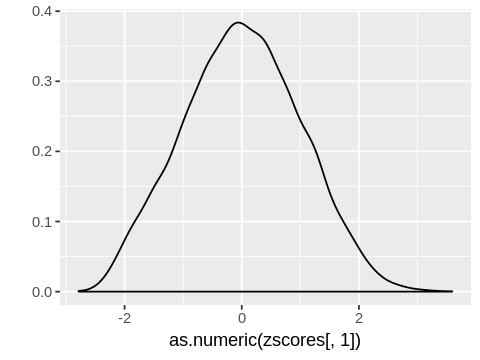

In [28]:
# and then we z-score transforming the scores

source('../shiny-app/Immune-Subtype-Clustering/src/signature_mclust_ensemble.R')

# and load the models trained on TCGA data #
load('../shiny-app/Immune-Subtype-Clustering/data/wolf_set_slim1.rda')

zscore.cols2<-function(x){
    return((apply(x, 2, function(x) (x - median(na.omit(x)))/sd(na.omit(x)))))
}

                  
# and we subset the 5 scores used in clustering
idx <- c("LIexpression_score", "CSF1_response", "TGFB_score_21050467", "Module3_IFN_score", "CHANG_CORE_SERUM_RESPONSE_UP")
scores <- t(scores[idx,])
zscores <- zscore.cols2(scores)

qplot(as.numeric(zscores[,1]), geom='density')

In [29]:
gc()
zscores[1:5,1:5]
dim(zscores)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3763760,201.1,6801121,363.3,8595245,459.1
Vcells,45291495,345.6,239116273,1824.4,275934593,2105.3


,LIexpression_score,CSF1_response,TGFB_score_21050467,Module3_IFN_score,CHANG_CORE_SERUM_RESPONSE_UP
rpkm.exp_005_shNTC_rep1,-0.17536535,-0.11262150,-0.3964733,1.2271757,0.5672085
rpkm.exp_005_shNTC_rep2,0.03524472,-0.09963384,-0.2746455,0.6123796,0.7038122
rpkm.exp_005_shNTC_rep3,-0.66020906,-0.38322850,-0.4858895,0.5972572,0.9744203
rpkm.exp_005_shTRPS1_seq1,0.13245376,0.60244151,0.5309529,0.2177159,-0.9351432
rpkm.exp_005_shTRPS1_seq2,0.17988537,0.11809486,0.3271011,-1.0029899,-0.0638254


[1] 9135    5

In [30]:

  # load the clustering model trained on all pancan data.
library(clue)
library(mclust)
library(parallel)
load("../shiny-app/Immune-Subtype-Clustering//data/wolf_set_slim1.rda")

  # make cluster calls using the models.
calls <- consensusEnsemble(mods2, zscores, 4, 256)
  

Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘mclust’

The following object is masked from ‘package:mgcv’:

    mvn

Iteration: 0 *** value: 8057.69


In [31]:
# get the top scoring cluster for each sample
maxcalls <- apply(calls$.Data, 1, function(a) which(a == max(a))[1])
names(maxcalls) <- rownames(scores)
  

In [54]:
  # then we'll look at the new vs. old cluster calls for TCGA samples
sharedIDs <- intersect(reportedScores$AliquotBarcode, rownames(scores))
t1 <-table(Reported=as.numeric(reportedScores[sharedIDs, 'ClusterModel1']),
             NewCalls=as.numeric(maxcalls[sharedIDs]))
t1

        NewCalls
Reported    1    2    3    4    5    6
       1   66 2268   24    0   24   34
       2 2556    3    9    0   12   12
       3    2   16    9    1   46 2323
       4   16   31    1    9 1044   58
       5    0    0    0  368   14    3
       6    8    8  122    0    6   36

In [33]:
# then we can align the new calls to old calls.
reported <- 1:6
optcalls <- 1:6

for (i in reported) {
    
    # for subtype i, where did most of the samples end up?
    j <- which(as.numeric(t1[i,]) == max(as.numeric(t1[i,])))
    # rename maxcall j <- i
    optcalls[i] <- j
}
  
print(optcalls)
  

[1] 2 1 6 5 4 3


In [34]:
  
# these are the re-mapped calls
alignedCalls <- sapply(maxcalls, function(a) which(a == optcalls)[1])


In [35]:
# make sure it works on the re-called TCGA data
t2 <-table(Reported=as.numeric(reportedScores[sharedIDs, 'ClusterModel1']),
             NewCalls=as.numeric(alignedCalls[sharedIDs]))

t2

        NewCalls
Reported    1    2    3    4    5    6
       1 2268   66   34   24    0   24
       2    3 2556   12   12    0    9
       3   16    2 2323   46    1    9
       4   31   16   58 1044    9    1
       5    0    0    3   14  368    0
       6    8    8   36    6    0  122

In [37]:
# assemble the results
jdx <- match(table=rownames(scores), x=colnames(newDatSub))  # index to new data scores
pcalls <- calls$.Data[jdx,]                            # get that table
rownames(pcalls) <- colnames(newDatSub)                      # name it from the new data
pcalls <- pcalls[,optcalls]
  
pcalls <- cbind(pcalls, data.frame(Call=alignedCalls[jdx]))  # bring in the aligned calls
pcalls <- cbind(pcalls, zscores[jdx,])                       # and the scores
    

In [38]:
head(pcalls)

,1,2,3,4,5,6,Call,LIexpression_score,CSF1_response,TGFB_score_21050467,Module3_IFN_score,CHANG_CORE_SERUM_RESPONSE_UP
rpkm.exp_005_shNTC_rep1,0.01953125,0.85156250,0.0000000,0.00390625,0.00000000,0.12500000,2,-0.17536535,-0.11262150,-0.3964733,1.2271757,0.5672085
rpkm.exp_005_shNTC_rep2,0.08593750,0.83203125,0.0000000,0.00000000,0.00000000,0.08203125,2,0.03524472,-0.09963384,-0.2746455,0.6123796,0.7038122
rpkm.exp_005_shNTC_rep3,0.05078125,0.78125000,0.0000000,0.01171875,0.00000000,0.15625000,2,-0.66020906,-0.38322850,-0.4858895,0.5972572,0.9744203
rpkm.exp_005_shTRPS1_seq1,0.00000000,0.00000000,0.7695312,0.00000000,0.00390625,0.22656250,3,0.13245376,0.60244151,0.5309529,0.2177159,-0.9351432
rpkm.exp_005_shTRPS1_seq2,0.89453125,0.01562500,0.0312500,0.00390625,0.00000000,0.05468750,1,0.17988537,0.11809486,0.3271011,-1.0029899,-0.0638254
rpkm.exp_005_shTRPS1_seq3,0.13671875,0.01953125,0.2890625,0.36718750,0.00000000,0.18750000,4,0.18217399,0.19091848,0.4086987,-1.6206701,-1.2017081


In [39]:
finalResults <- list(AlignedCalls=alignedCalls[jdx], Table=t2, ProbCalls=pcalls)

In [42]:
# In the finalResults,
# $AlignedCalls are the immune subtypes - aligned with the TCGA manuscript
# $Table is the TCGA reported immune subtypes (on TCGA samples) compared to what we just computed
# $ProbCalls shows the probability of being in each subtype and signature scores, Call is the aligned call


head(finalResults)

$AlignedCalls
  rpkm.exp_005_shNTC_rep1   rpkm.exp_005_shNTC_rep2   rpkm.exp_005_shNTC_rep3 
                        2                         2                         2 
rpkm.exp_005_shTRPS1_seq1 rpkm.exp_005_shTRPS1_seq2 rpkm.exp_005_shTRPS1_seq3 
                        3                         1                         4 

$Table
        NewCalls
Reported    1    2    3    4    5    6
       1 2268   66   34   24    0   24
       2    3 2556   12   12    0    9
       3   16    2 2323   46    1    9
       4   31   16   58 1044    9    1
       5    0    0    3   14  368    0
       6    8    8   36    6    0  122

$ProbCalls
                                   1          2         3          4          5
rpkm.exp_005_shNTC_rep1   0.01953125 0.85156250 0.0000000 0.00390625 0.00000000
rpkm.exp_005_shNTC_rep2   0.08593750 0.83203125 0.0000000 0.00000000 0.00000000
rpkm.exp_005_shNTC_rep3   0.05078125 0.78125000 0.0000000 0.01171875 0.00000000
rpkm.exp_005_shTRPS1_seq1 0.00000000 0.0